#### Data cleaning and preprocessing

In [4]:
import pandas as pd

In [5]:
# Loading the dataset into pandas and displaying first 5 rows
df=pd.read_csv("cardekho.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [6]:
# Calculate missing values count and percentage
missing_count = df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_count / len(df)) * 100

# Combine into one DataFrame
missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percentage
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

# Sort by percentage of missing values
missing_df = missing_df.sort_values(by='Percentage (%)', ascending=False)
print(missing_df)

                    Missing Values  Percentage (%)
mileage(km/ltr/kg)             221        2.718996
engine                         221        2.718996
seats                          221        2.718996
max_power                      215        2.645177


In [7]:
# Dropping rows with missing variable
df = df.dropna(subset=['selling_price']) # Without target values, the model has nothing to learn from

In [8]:
# Fill missing values in the "mileage" column with the column’s mean
mileage_mean = df["mileage(km/ltr/kg)"].mean()
df["mileage(km/ltr/kg)"] = df["mileage(km/ltr/kg)"].fillna(mileage_mean) # Filling missing values keeps more data for training, which often leads to better results than throwing rows away
df["mileage(km/ltr/kg)"]


0       23.40
1       21.14
2       17.70
3       23.00
4       16.10
        ...  
8123    18.50
8124    16.80
8125    19.30
8126    23.57
8127    23.57
Name: mileage(km/ltr/kg), Length: 8128, dtype: float64

In [9]:
# Remove duplicate rows from the dataset - Duplicates can make the model overemphasize repeated patterns, leading to biased and less accurate predictions
duplicates_count = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_count


np.int64(1202)

In [10]:
# Convert the “year” column into the car’s age
from datetime import datetime

# Get current year
current_year = datetime.now().year

# Convert "year" to car's age
df["car_age"] = current_year - df["year"]

# View results
print(df[["year", "car_age"]].head())


   year  car_age
0  2014       11
1  2014       11
2  2006       19
3  2010       15
4  2007       18


In [12]:
# Check the unique values in the “fuel type” column
df["fuel"].unique() #Knowing all categories prevents mistakes during encoding and ensures the model handles every possible value correctly


array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [13]:
#Replace inconsistent values in the “transmission” column - consistent casing
df["transmission"] = df["transmission"].str.strip().str.capitalize()

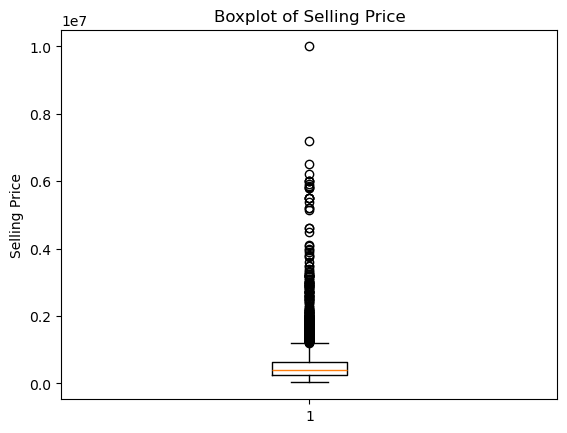

In [14]:
#Check if there are any outliers in the “selling price” column using a boxplot.
#Outliers can pull the model toward extreme values, making predictions less accurate for typical cases
import matplotlib.pyplot as plt

plt.boxplot(df["selling_price"])
plt.title("Boxplot of Selling Price")
plt.ylabel("Selling Price")
plt.show()


In [15]:
# Remove cars that are priced below 10,000 or above 5,000,000 (possible outliers).
df = df[(df["selling_price"] >= 10000) & (df["selling_price"] <= 5000000)]
#Price limits remove unrealistic data so the model learns from values it’s more likely to predict correctly

In [16]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [17]:
# Identify object columns that might be numbers stored as strings
for col in df.select_dtypes(include='object').columns:
    try:
        # Try converting to numeric
        df[col] = pd.to_numeric(df[col], errors='ignore')
    except:
        pass

# Verify the data types after conversion
print(df.dtypes)


name                   object
year                    int64
selling_price           int64
km_driven               int64
fuel                   object
seller_type            object
transmission           object
owner                  object
mileage(km/ltr/kg)    float64
engine                float64
max_power              object
seats                 float64
car_age                 int64
dtype: object


C:\Users\pc\AppData\Local\Temp\ipykernel_4164\2433055757.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [24]:
# Create a new column for “price per kilometer” by dividing the selling price by the mileage.
df["price_per_kilometer"] = df["selling_price"] / df["mileage(km/ltr/kg)"]
df["price_per_kilometer"] = df["price_per_kilometer"].replace(
    [float('inf'), -float('inf')], None
)
df["price_per_kilometer"] = pd.to_numeric(df["price_per_kilometer"], errors="coerce")


In [25]:
# the dataset index is properly reset after cleaning
df.reset_index(drop=True, inplace=True)

In [26]:
df.to_csv("cleaned_cars.csv", index=False)

#### Exploratory data analysis

In [ ]:
#average selling price of cars
average_price = df["selling_price"].mean()
print(f"Average selling price: {average_price:.2f}")

Average selling price: 501378.18


In [32]:
#most common fuel type
most_common_fuel = df["fuel"].mode()[0]
print(f"Most common fuel type: {most_common_fuel}")
#counts for each type
fuel_counts = df["fuel"].value_counts()
print(fuel_counts)

Most common fuel type: Diesel
fuel
Diesel    3741
Petrol    3071
CNG         56
LPG         38
Name: count, dtype: int64


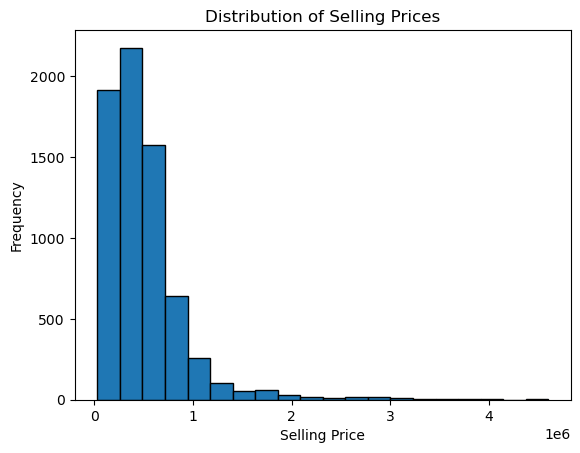

In [35]:
#Plot a histogram of the selling prices
import matplotlib.pyplot as plt

plt.hist(df["selling_price"], bins=20, edgecolor="black")
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()


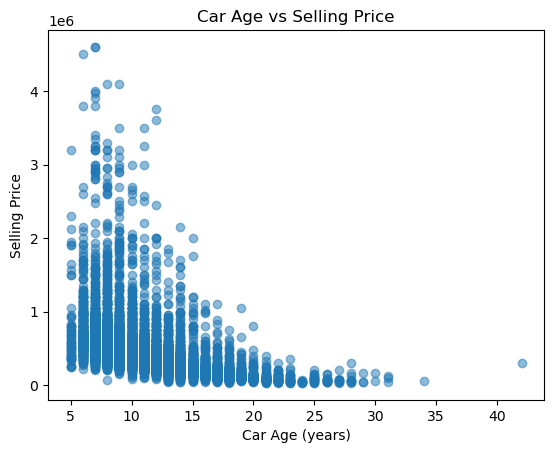

In [36]:
#Plot the relationship between car age and selling price using a scatter plot.
import matplotlib.pyplot as plt

plt.scatter(df["car_age"], df["selling_price"], alpha=0.5)
plt.title("Car Age vs Selling Price")
plt.xlabel("Car Age (years)")
plt.ylabel("Selling Price")
plt.show()


In [ ]:
#Group cars by fuel type and find the average selling price for each group.
avg_price_by_fuel = df.groupby("fuel")["selling_price"].mean()

print(avg_price_by_fuel)


fuel
CNG       300499.946429
Diesel    620448.482224
LPG       200421.052632
Petrol    363717.339629
Name: selling_price, dtype: float64


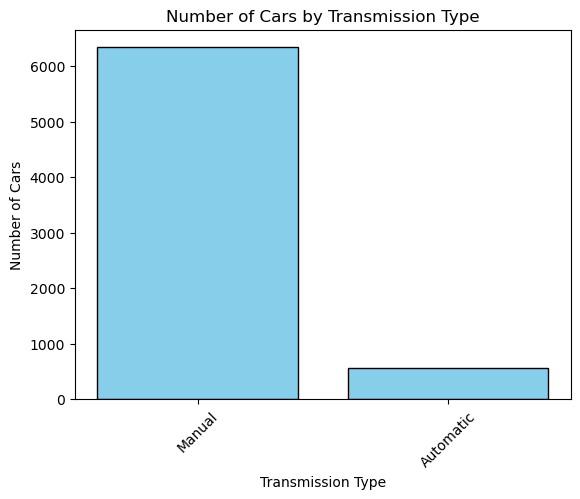

In [40]:
#Plot a bar chart showing the number of cars per transmission type
import matplotlib.pyplot as plt

# Count cars by transmission type
transmission_counts = df["transmission"].value_counts()

# Plot bar chart
plt.bar(transmission_counts.index, transmission_counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Cars by Transmission Type")
plt.xlabel("Transmission Type")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.show()


In [41]:
#Find the car with the highest mileage in the dataset
highest_mileage_car = df.loc[df["mileage(km/ltr/kg)"].idxmax()]
print(highest_mileage_car)

name                   Maruti Alto 800 CNG LXI Optional
year                                               2019
selling_price                                    330000
km_driven                                         10000
fuel                                                CNG
seller_type                                  Individual
transmission                                     Manual
owner                                      Second Owner
mileage(km/ltr/kg)                                33.44
engine                                            796.0
max_power                                          40.3
seats                                               4.0
car_age                                               6
price_per_kilometer                         9868.421053
Name: 35, dtype: object


In [42]:
#Calculate the correlation between mileage and selling price.
correlation = df["mileage(km/ltr/kg)"].corr(df["selling_price"])
print(f"Correlation between mileage and selling price: {correlation:.4f}")

Correlation between mileage and selling price: -0.1207


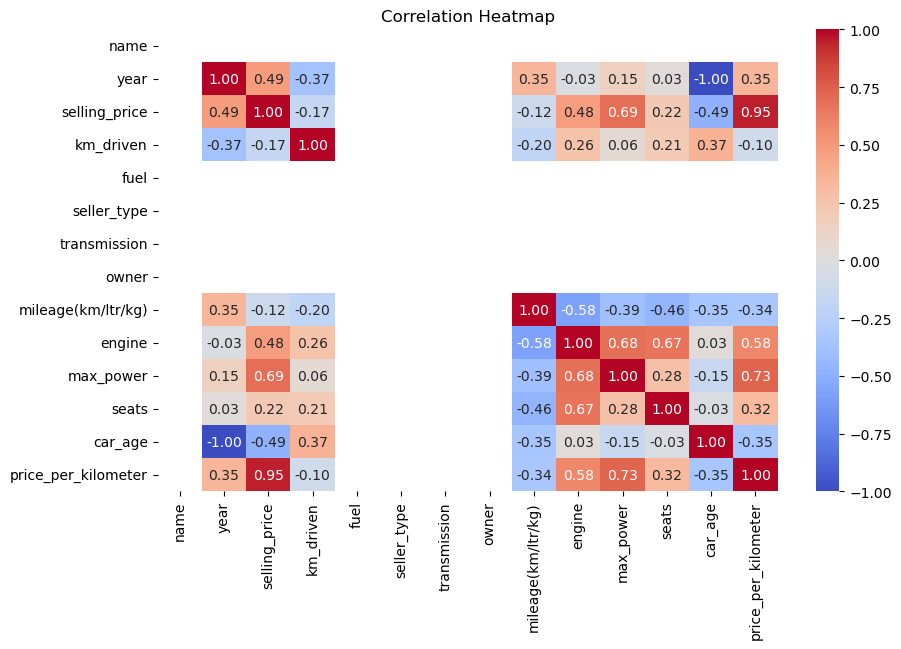

In [ ]:
#Plot a heatmap showing the correlations between all numeric columns.
import seaborn as sns

# Convert numeric-looking object columns to numbers
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Calculate correlation matrix for numeric columns only
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Check if manual cars are generally cheaper or more expensive than automatic cars.
df = pd.read_csv("cleaned_cars.csv")
print(df["transmission"].unique())
# Calculate average price per transmission type
avg_prices = df.groupby("transmission")["selling_price"].mean()

# Identify cheaper type
cheaper_type = avg_prices.idxmin()

print(avg_prices)
print(f"Cheaper type: {cheaper_type}")

['Manual' 'Automatic']
transmission
Automatic    1.143215e+06
Manual       4.442991e+05
Name: selling_price, dtype: float64
Cheaper type: Manual


In [65]:
#Find the average selling price for each year of manufacture.
df = pd.read_csv("cleaned_cars.csv")

# Average selling price per year of manufacture
avg_price_by_year = df.groupby("year")["selling_price"].mean().sort_index()

print(avg_price_by_year.head())


year
1983    300000.000000
1991     55000.000000
1994     88000.000000
1995    107500.000000
1996     81666.666667
Name: selling_price, dtype: float64


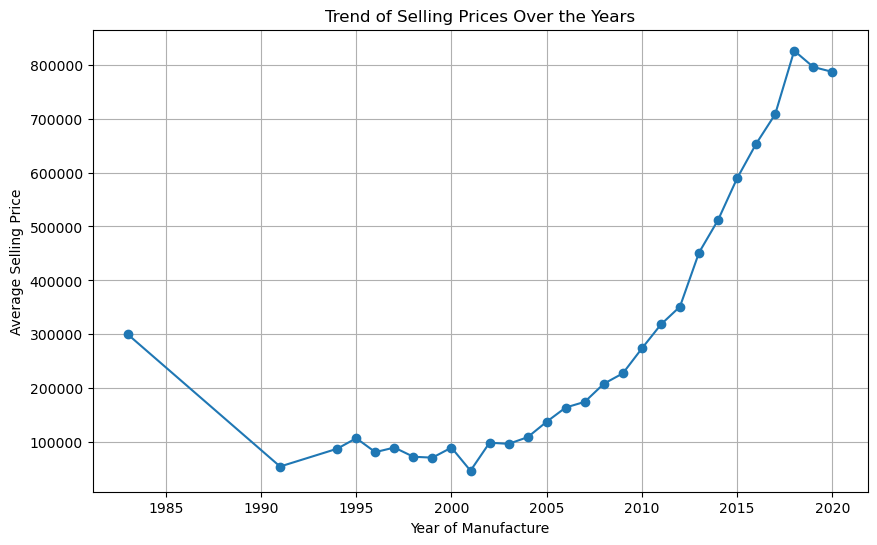

In [62]:
# Group and average selling price by year
avg_price_by_year = df.groupby("year")["selling_price"].mean().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_price_by_year.index, avg_price_by_year.values, marker='o', linestyle='-')
plt.xlabel("Year of Manufacture")
plt.ylabel("Average Selling Price")
plt.title("Trend of Selling Prices Over the Years")
plt.grid(True)
plt.show()

In [66]:
# Find the most expensive car for each fuel type
most_expensive_by_fuel = df.loc[df.groupby("fuel")["selling_price"].idxmax()]

print(most_expensive_by_fuel[["fuel", "name", "selling_price"]])


        fuel                                      name  selling_price
4961     CNG     Maruti Ertiga VXI CNG Limited Edition         545000
283   Diesel  Mercedes-Benz GL-Class 220d 4MATIC Sport        4600000
2783     LPG               Hyundai i10 Sportz 1.1L LPG         375000
133   Petrol           Jeep Wrangler 2016-2019 3.6 4X4        4100000


In [68]:
#find out which brand appears most frequently in the dataset.
df["brand"] = df["name"].str.split().str[0]

# Find the most frequent brand
most_common_brand = df["brand"].value_counts().idxmax()
brand_count = df["brand"].value_counts().max()

print(f"The most common brand is {most_common_brand} with {brand_count} cars.")

The most common brand is Maruti with 2165 cars.


In [70]:
#Check the top 5 most common combinations of fuel type and transmission.
top_combos = (
    df.groupby(["fuel", "transmission"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .head(5)
)

print(top_combos)

     fuel transmission  count
2  Diesel       Manual   3457
5  Petrol       Manual   2791
1  Diesel    Automatic    284
4  Petrol    Automatic    280
0     CNG       Manual     56


#### Machine Learning

##### Main Assumptions of Linear Regression

**Linearity**
- The relationship between predictors (independent variables) and the target (dependent variable) should be linear.

- Violation means the model won’t capture trends well.

Check: Scatter plots or residuals vs fitted values plots.

**Homoscedasticity**

- The residuals should have constant variance across all fitted values.

- Violation means unequal spread → leads to unreliable predictions.

Check: Residuals vs fitted values plot.

**Normality of Residuals**

- The residuals should follow a normal distribution.

- This is important for valid hypothesis testing and confidence intervals.

Check: Histogram of residuals, Q-Q plot, or Shapiro-Wilk test.

**No Multicollinearity**

- Independent variables should not be highly correlated with each other.

- High correlation inflates standard errors.

Check: Variance Inflation Factor (VIF).

**Independence of Errors**

- Residuals should be independent (no autocorrelation).

- Violation is common in time-series data.

Check: Durbin-Watson statistic.